In [129]:
import gzip
import pickle

import ra_pickles
from calo.event_generator import EventGenerator
import numpy as np
import tensorflow as tf
from calo.config import is_laptop

from matplotlib import pyplot as plt

In [114]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calibration dataset
A set of simulations are used to perform the calibration. $\gamma$ should be used for EM particlese and $\pi^+$ for hadrons. This has been
tested with $2000$ particles in each of the categories. `run_simulations.py` script can be used to generate these datasets (within the
singularity/docker container). The recommended properties are $1.7 < |\eta| < 2.8$ and $0.1 < E~\mathrm{[GeV]} < 200$. Change the paths
accordingly. A calibration dataset can also be downloaded, as it follows:

In [ ]:
import requests
import zipfile
import shutil
import os

def download(url, filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)

if os.path.exists('data'):
    shutil.rmtree('data')
if os.path.exists('data.zip'):
    os.unlink('data.zip')

download('https://github.com/shahrukhqasim/hg_toy_calorimeter_data/raw/master/data.zip', 'data.zip')
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

os.unlink('data.zip')

# Sensor data
Sensor data can be extracted by running `extract_sensor_data.py`. It can also be downloaded, as it follows:

In [ ]:
if os.path.exists('sensor_data_v3.bin'):
    os.unlink('sensor_data_v3.bin')

download('https://github.com/shahrukhqasim/hg_toy_calorimeter_data/raw/master/sensor_data_v3.bin', 'sensor_data_v3.bin')

Load the calibration and sensor data into memory:

In [115]:
em_path = 'data/em'
had_path = 'data/had'

em_reader = ra_pickles.RandomAccessPicklesReader(em_path)
had_reader = ra_pickles.RandomAccessPicklesReader(had_path)

em_sims = [em_reader.get_element(x) for x in range(em_reader.get_total())]
had_sims = [had_reader.get_element(x) for x in range(had_reader.get_total())]

with gzip.open('sensor_data_v3.bin', 'rb') as f:
    sensor_data = pickle.load(f)
    
print('There are %d electromagnetic samples and %d hadronic samples'%(len(em_sims), len(had_sims)))

print('There are %d sensors in the detector'%len(sensor_data['sensors_x']))

Reading meta files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6829.22it/s]


Reading meta files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7359.98it/s]


There are 2000 electromagnetic samples and 2000 hadronic samples
There are 3102332 sensors in the detector


`sensors_scaling` is used to scale the sensor reading by the `EventGenerator`. Begin by setting it according to its pre-absorber thickness:

In [116]:
sensor_scaling = 1 + sensor_data['sensors_pre_absorber_thickness']/sensor_data['sensors_thickness']
global_scaling_factor = 2.9
sensor_scaling = sensor_scaling * global_scaling_factor
sensor_data['sensors_scaling'] = sensor_scaling

In [117]:
cut = 0.000
cut_2 = 0.0009

# EM Calibration

In [118]:
noise_fluctuations = ('type_a', 0, 5.2e-13) # Noise level set to a very low value
gen = EventGenerator(sensor_data, noise_fluctuations, cut=cut_2, num_hits_cut=3,
                     reduce=True, area_normed_cut=True, merge_closeby_particles=False, verbose=False,
                    collect_truth=False)



In [119]:
from tqdm import tqdm

print(len(em_sims))

N = len(em_sims)
# N = min(100, N)


em_dep = []
em_true = []
for i in tqdm(range(N)):
    sim = em_sims[i]
    gen.add([sim[0]])
    result = gen.process()
    em_dep += [np.sum(result['rechit_energy'])]
    em_true += [sim[1]['energy']]


2000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:31<00:00,  2.46it/s]


In [120]:
em_dep = np.array(em_dep, np.float32)
em_true = np.array(em_true, np.float32)

g_em, _, _, _ = np.linalg.lstsq(em_dep[:, np.newaxis], em_true[:, np.newaxis])

print("EM calibration constant is", g_em)
g_em = g_em[0][0]

EM calibration constant is [[1.0316283]]


/var/folders/4v/gfv88pzj0cg0f6mpfd5pd09m0000gn/T/ipykernel_1207/1789735089.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_em, _, _, _ = np.linalg.lstsq(em_dep[:, np.newaxis], em_true[:, np.newaxis])


# Hadronic calibration

Once the sensors have been calibrated with photons ($\gamma$), the calibration constant in the EM layers is frozen and the the rest is calibrated with charged pions ($\pi^+$).

In [121]:
from copy import deepcopy

sensor_data_calibrated_no_had = deepcopy(sensor_data)
sensor_data_calibrated_no_had['sensors_scaling'][sensor_data_calibrated_no_had['sensors_active_layer_num']>=28] = 0.0
sensor_data_calibrated_no_had['sensors_scaling'] = sensor_data_calibrated_no_had['sensors_scaling'] * g_em

gen_calibrated_no_had = EventGenerator(sensor_data_calibrated_no_had, noise_fluctuations, cut=cut,
                                       num_hits_cut=3, reduce=True, area_normed_cut=True,
                                       merge_closeby_particles=False, collect_truth=False)


sensor_data_no_em = deepcopy(sensor_data)
sensor_data_no_em['sensors_scaling'][sensor_data_calibrated_no_had['sensors_active_layer_num']<28] = 0.0

gen_no_em = EventGenerator(sensor_data_no_em, noise_fluctuations, cut=cut,
                                       num_hits_cut=3, reduce=True, area_normed_cut=True,
                                       merge_closeby_particles=False, collect_truth=False)

$E_{\mathrm{dep}}$

In [122]:
print(len(had_sims))

N = len(had_sims)
# N = min(100, N)


had_dep = []
had_true = []
for i in tqdm(range(N)):
    sim = had_sims[i]

    gen_calibrated_no_had.add([sim[0]])
    result_c_no_had = gen_calibrated_no_had.process()
    
    gen_no_em.add([sim[0]])
    result_no_em = gen_no_em.process()
    
    dep_on_em_layers = np.sum(result_c_no_had['rechit_energy'])    
    had_true += [sim[1]['energy'] - dep_on_em_layers]

    had_dep += [np.sum(result_no_em['rechit_energy'])]


2000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [30:57<00:00,  1.08it/s]


In [125]:
had_dep = np.array(had_dep, np.float32)
had_true = np.array(had_true, np.float32)

print(sensor_data['sensors_scaling'])

filter = np.logical_and(0.5 < had_dep / had_true, had_dep / had_true < 2 )
filter = np.logical_and(filter, had_true > 5)

# filter = np.logical_or(filter, True)

g_had, _, _, _ = np.linalg.lstsq(had_dep[filter][:, np.newaxis], had_true[filter][:, np.newaxis])

print("Had calibration constant is", g_had)
g_had = g_had[0][0]

[   2.9     2.9     2.9  ... 1098.23 1098.23 1098.23]
Had calibration constant is [[1.1859236]]


/var/folders/4v/gfv88pzj0cg0f6mpfd5pd09m0000gn/T/ipykernel_1207/2747486787.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_had, _, _, _ = np.linalg.lstsq(had_dep[filter][:, np.newaxis], had_true[filter][:, np.newaxis])


In [126]:
# g_had = 5.077009
# g_em = 3.4087722

In [127]:
sensor_data_calibrated = deepcopy(sensor_data)
sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']<28]\
= sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']<28] * g_em


sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']>=28]\
= sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']>=28] * g_had


print(sensor_data_calibrated['sensors_scaling'])


gen_calibrated = EventGenerator(sensor_data_calibrated, noise_fluctuations, cut=cut_2,
                                       num_hits_cut=3, reduce=True, area_normed_cut=True,
                                       merge_closeby_particles=False, collect_truth=False)

    
sensor_data_calibrated_em_only = deepcopy(sensor_data)
sensor_data_calibrated_em_only['sensors_scaling']\
= sensor_data_calibrated_em_only['sensors_scaling'] * g_em

print(sensor_data_calibrated_em_only['sensors_scaling'])

    
gen_calibrated_only_em = EventGenerator(sensor_data_calibrated_em_only, noise_fluctuations, cut=cut_2,
                                       num_hits_cut=3, reduce=True, area_normed_cut=True,
                                       merge_closeby_particles=False, collect_truth=False)

[   2.99172193    2.99172193    2.99172193 ... 1302.41684926 1302.41684926
 1302.41684926]
[   2.99172193    2.99172193    2.99172193 ... 1132.96509418 1132.96509418
 1132.96509418]


In [ ]:
print(len(had_sims))

N = min(len(had_sims), len(em_sims))
# N = min(100, N)

E_dep_em_had = []
E_dep_em  = []
E_true = []

for i in tqdm(range(N)):
    sim = had_sims[i]

    gen_calibrated.add([sim[0]])
    result_calibrated = gen_calibrated.process()
    
    gen_calibrated_only_em.add([sim[0]])
    result_calibrated_only_em = gen_calibrated_only_em.process()
    
    e_dep_em_had = np.sum(result_calibrated['rechit_energy'])
    e_dep_em = np.sum(result_calibrated_only_em['rechit_energy'])
    e_true = sim[1]['energy']
    
    E_dep_em_had += [e_dep_em_had]
    E_dep_em += [e_dep_em]
    E_true += [e_true]
    
    print('E', sim[1]['energy'],'E_dep [had+em calib]',\
         np.sum(result_calibrated['rechit_energy']), 'E_dep [em calib]',\
         np.sum(result_calibrated_only_em['rechit_energy']))
    
    
E_dep_em_had = np.array(E_dep_em_had)
E_dep_em  = np.array(E_dep_em)
E_true = np.array(E_true)

In [131]:
E_dep_em_had = np.array(E_dep_em_had)
E_dep_em  = np.array(E_dep_em)
E_true = np.array(E_true)
data_em = {
    'E_dep_em_had':E_dep_em_had,
    'E_dep_em':E_dep_em,
    'E_true':E_true,
    'g_em':g_em,
    'g_had':g_had,
}

with gzip.open('had_calib_data.bin', 'wb') as f:
    pickle.dump(data_em,f) 

Text(0, 0.5, 'E$_\\mathrm{dep}$')

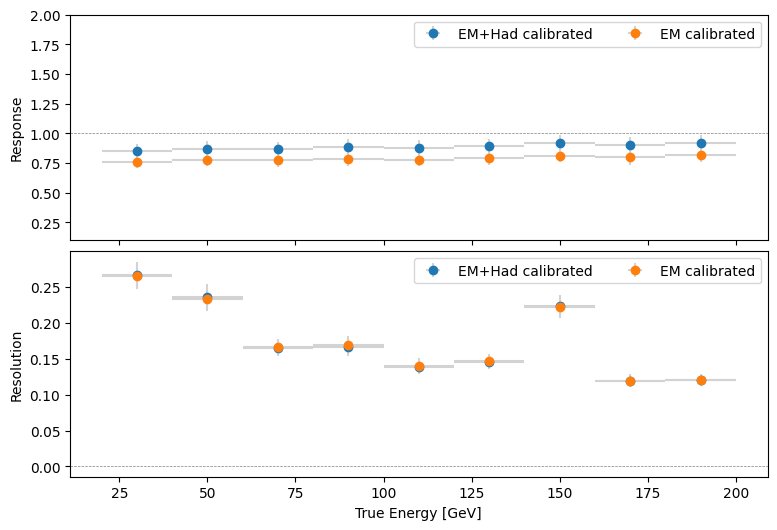

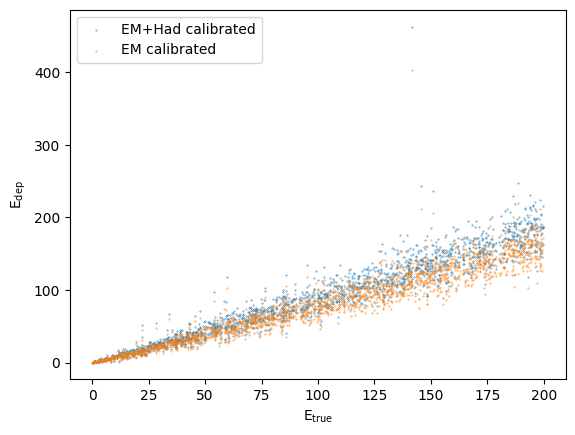

In [132]:
from plotting.general_2d_plot_extensions_2 import ResponseAndResolutionCombinedPlot

binning = np.array([20, 40, 60, 80, 100, 120,140,160,180,200])
plot = ResponseAndResolutionCombinedPlot(bins=binning, x_label='True Energy [GeV]',
                                         y_label1='Response',
                                         y_label2='Resolution',
                                         histogram_log=False,
                                         plot_background_distribution=False, resolution_by_fit=False)

plot.add_raw_values(E_true, E_dep_em_had/E_true,
                                tags={'calib':'both'})

plot.add_raw_values(E_true, E_dep_em/E_true,
                                tags={'calib':'em'})

mydict = {'em':'EM calibrated', 'both': 'EM+Had calibrated'}

name_tag_formatter = lambda x: mydict[x['calib']]
fig = plot.draw(name_tag_formatter=name_tag_formatter, markersize=6, type_='points')

fig,ax = plt.subplots()
ax.scatter(E_true, E_dep_em_had, s=0.1, label=mydict['both'])
ax.scatter(E_true, E_dep_em, s=0.1, label=mydict['em'])
ax.legend()
ax.set_xlabel('E$_\\mathrm{true}$')
ax.set_ylabel('E$_\\mathrm{dep}$')


In [ ]:
print(len(had_sims))

N = min(len(had_sims), len(em_sims))
# N = min(100, N)

EM_E_dep_em_had = []
EM_E_dep_em  = []
EM_E_true = []

for i in tqdm(range(N)):
    sim = em_sims[i]

    gen_calibrated.add([sim[0]])
    result_calibrated = gen_calibrated.process()
    
    gen_calibrated_only_em.add([sim[0]])
    result_calibrated_only_em = gen_calibrated_only_em.process()
    
    e_dep_em_had = np.sum(result_calibrated['rechit_energy'])
    e_dep_em = np.sum(result_calibrated_only_em['rechit_energy'])
    e_true = sim[1]['energy']
    
    EM_E_dep_em_had += [e_dep_em_had]
    EM_E_dep_em += [e_dep_em]
    EM_E_true += [e_true]
    
    print('E', sim[1]['energy'],'E_dep [had+em calib]',\
         np.sum(result_calibrated['rechit_energy']), 'E_dep [em calib]',\
         np.sum(result_calibrated_only_em['rechit_energy']))
    
    
EM_E_dep_em_had = np.array(EM_E_dep_em_had)
EM_E_dep_em  = np.array(EM_E_dep_em)
EM_E_true = np.array(EM_E_true)
data_em = {
    'EM_E_dep_em_had':EM_E_dep_em_had,
    'EM_E_dep_em':EM_E_dep_em_had,
    'EM_E_true':EM_E_dep_em_had,
    'g_em':g_em,
    'g_had':g_had,
}

with gzip.open('em_calib_data.bin', 'wb') as f:
    pickle.dump(data_em,f) 

In [71]:
with gzip.open('em_calib_data.bin', 'rb') as f:
    data_em = pickle.load(f) 

Text(0, 0.5, 'E$_\\mathrm{dep}$')

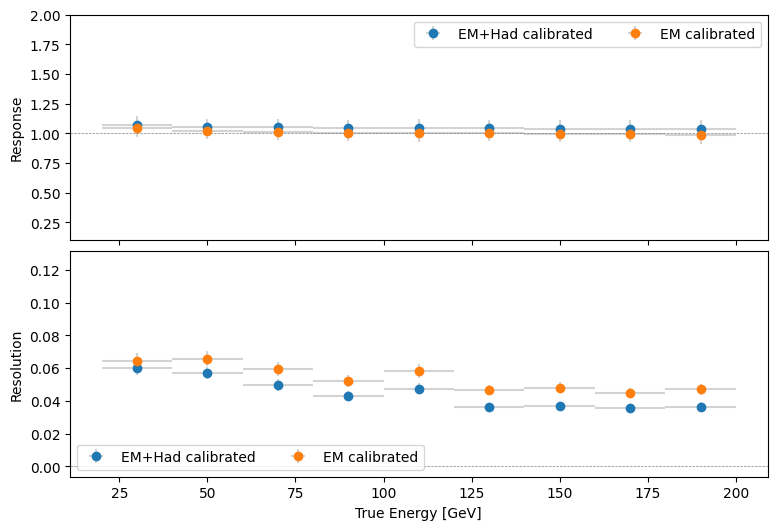

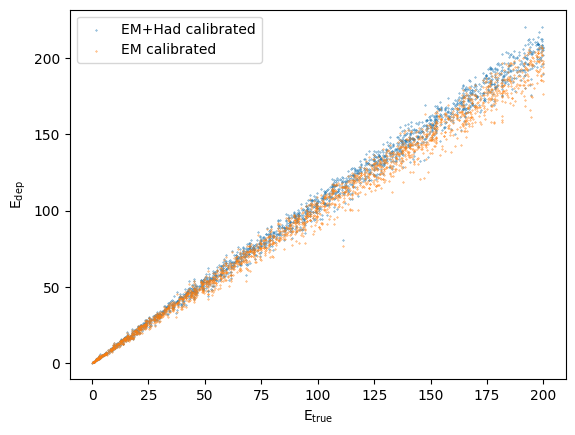

In [134]:
from plotting.general_2d_plot_extensions_2 import ResponseAndResolutionCombinedPlot

binning = np.array([20, 40, 60, 80, 100, 120,140,160,180,200])
plot = ResponseAndResolutionCombinedPlot(bins=binning, x_label='True Energy [GeV]',
                                         y_label1='Response',
                                         y_label2='Resolution',
                                         histogram_log=False,
                                         plot_background_distribution=False, resolution_by_fit=False)

plot.add_raw_values(EM_E_true, EM_E_dep_em_had/EM_E_true,
                                tags={'calib':'both'})

plot.add_raw_values(EM_E_true, EM_E_dep_em/EM_E_true,
                                tags={'calib':'em'})

mydict = {'em':'EM calibrated', 'both': 'EM+Had calibrated'}

name_tag_formatter = lambda x: mydict[x['calib']]
plot.draw(name_tag_formatter=name_tag_formatter, markersize=6, type_='points')



fig,ax = plt.subplots()
ax.scatter(EM_E_true, EM_E_dep_em_had, s=0.1, label=mydict['both'])
ax.scatter(EM_E_true, EM_E_dep_em, s=0.1, label=mydict['em'])
ax.legend()
ax.set_xlabel('E$_\\mathrm{true}$')
ax.set_ylabel('E$_\\mathrm{dep}$')

In [74]:
sensor_data_calibrated = deepcopy(sensor_data)
sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']<28]\
= sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']<28] * g_em


sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']>=28]\
= sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']>=28] * g_had

print(sensor_data_calibrated['sensors_scaling'])

with gzip.open('sensor_data_v3_calibrated.bin', 'wb') as f:
    pickle.dump(sensor_data_calibrated, f)

[   2.96685765    2.96685765    2.96685765 ... 1247.02623729 1247.02623729
 1247.02623729]
